In [11]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
wholepath="/content/drive/MyDrive/agriculturedset/dataset_project/mdset2"
imagespath=wholepath+"/"+"aug_image"
labelpath=wholepath+"/"+"aug_mask"

In [14]:
import tensorflow as tf
import segmentation_models as sm
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

In [15]:
BACKBONE='vgg16'
preprocess_input=sm.get_preprocessing(BACKBONE)

In [16]:
labelpathcontents=sorted(os.listdir(labelpath))
imagepathcontents=sorted(os.listdir(imagespath))

In [17]:
labelMask=[]
for i in range(2000):
  labelImg=skimage.io.imread(labelpath+"/"+labelpathcontents[i],0)
  labelImg[labelImg>0]=255
  
  #print(np.unique(labelImg)," ",i)
  labelMask.append(labelImg)

In [18]:
sample_image=labelMask[0]

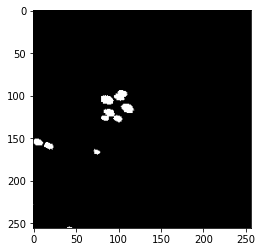

In [19]:
plt.imshow(sample_image,cmap=plt.cm.gray)

In [20]:
imgMask=[]
for i in range(2000):
  mainImg=skimage.io.imread(imagespath+"/"+imagepathcontents[i])
  mainImg1=np.array([mainImg[i][j][0] for i in range(mainImg.shape[0]) for j in range(mainImg.shape[1])])
  mainImg1=np.reshape(mainImg1,newshape=(mainImg.shape[0],mainImg.shape[1]))
  imgMask.append(mainImg1)

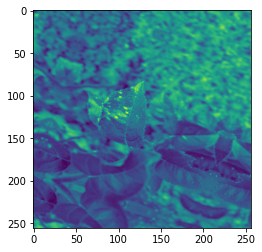

In [21]:
sample_in_image=imgMask[0]
plt.imshow(sample_in_image)

In [22]:
labelMask=np.array(labelMask,dtype=np.float32)
imgMask=np.array(imgMask,dtype=np.float32)

In [23]:
print(labelMask.shape)
print(imgMask.shape)

(2000, 256, 256)
(2000, 256, 256)


In [24]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

set_trainable used for encoder_freeze option

In [25]:
from segmentation_models.utils import set_trainable
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split

splitting of training and test data

In [26]:
X_train, X_test, y_train, y_test  = train_test_split(
                    imgMask, labelMask, test_size = 0.2, random_state = 0,shuffle=True)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=0,shuffle=True)

In [27]:
#X_train=preprocess_input(X_train)
#X_test=preprocess_input(X_test)
#y_train=preprocess_input(y_train)
y_train[y_train>0]=1
y_val[y_val>0]=1
Xtestcopy=np.array(X_test,dtype=np.uint8)

In [28]:
model=sm.Unet(BACKBONE,input_shape=(None,None,1),encoder_weights=None,activation='tanh')

In [29]:
model.compile('Adam',loss=bce_jaccard_loss, metrics=[iou_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   640         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

In [30]:
history=model.fit(x=X_train, y=y_train, batch_size = 40, verbose=1, epochs=10,validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 65s 1s/step - loss: 1.6101 - iou_score: 0.0354 - val_loss: 1.6310 - val_iou_score: 0.0484
Epoch 2/10
32/32 [==============================] - 34s 1s/step - loss: 1.4306 - iou_score: 0.0451 - val_loss: 1.6307 - val_iou_score: 0.0488
Epoch 3/10
32/32 [==============================] - 37s 1s/step - loss: 1.3976 - iou_score: 0.0370 - val_loss: 1.6296 - val_iou_score: 0.0506
Epoch 4/10
32/32 [==============================] - 38s 1s/step - loss: 1.3040 - iou_score: 0.0501 - val_loss: 1.5979 - val_iou_score: 0.0590
Epoch 5/10
32/32 [==============================] - 38s 1s/step - loss: 1.3643 - iou_score: 0.0613 - val_loss: 1.4887 - val_iou_score: 0.0313
Epoch 6/10
32/32 [==============================] - 38s 1s/step - loss: 1.2735 - iou_score: 0.0453 - val_loss: 1.6372 - val_iou_score: 0.0442
Epoch 7/10
32/32 [==============================] - 38s 1s/step - loss: 1.2685 - iou_score: -0.0017 - val_loss: 1.6355 - val_iou_score: 0.0435
Epoch

In [31]:
print(y_train.shape)
print(X_train.shape)

(1280, 256, 256)
(1280, 256, 256)


In [32]:
ypred=model.predict(X_test)
for i in range(ypred.shape[0]):
  j=ypred[i]
  j[j>0]=255
  ypred[i]=j




13/13 [==============================] - 18s 662ms/step


In [33]:
ypred=model.predict(X_test)
print(ypred[0])
print(np.unique(ypred[0]))

13/13 [==============================] - 3s 236ms/step
[[[-0.9567728 ]
  [-0.98754275]
  [-0.99280447]
  ...
  [-0.9498584 ]
  [-0.6997641 ]
  [-0.26619476]]

 [[-0.9974609 ]
  [-0.9999008 ]
  [-0.9999741 ]
  ...
  [-0.9945351 ]
  [-0.89594126]
  [-0.57236624]]

 [[-0.9998357 ]
  [-0.99999845]
  [-0.99999946]
  ...
  [-0.99879706]
  [-0.83790636]
  [-0.6070191 ]]

 ...

 [[-0.999943  ]
  [-0.99999964]
  [-1.        ]
  ...
  [-0.9954513 ]
  [-0.2980205 ]
  [-0.54208803]]

 [[-0.9983889 ]
  [-0.99995196]
  [-0.99995494]
  ...
  [-0.86050296]
  [ 0.3480252 ]
  [-0.5195146 ]]

 [[-0.9252455 ]
  [-0.9925864 ]
  [-0.9948197 ]
  ...
  [-0.75217015]
  [ 0.03333519]
  [-0.49022305]]]
[-1.         -0.9999999  -0.9999998  ... -0.08194671  0.03333519
  0.3480252 ]


In [34]:
ypred[1][ypred[1]>0]=255
ypred[1][ypred[1]<0]=0

In [35]:
img=np.array(ypred[1],dtype = np.float32)
img=np.reshape(img,(img.shape[0],img.shape[1]))

    Predictedf and actual test images respectively

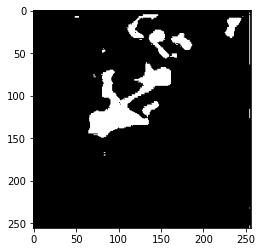

In [36]:
plt.imshow(img,cmap=plt.cm.gray)

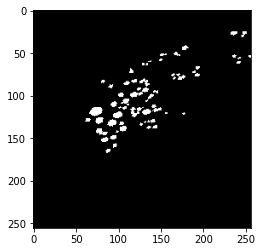

In [37]:
plt.imshow(y_test[1],cmap=plt.cm.gray)

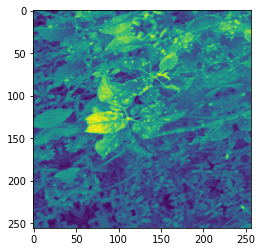

In [38]:
plt.imshow(X_test[1])